<a href="https://www.kaggle.com/code/rasheedj/braintumourdetectormodel?scriptVersionId=236848149" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!gdown 1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj

Downloading...
From (original): https://drive.google.com/uc?id=1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj
From (redirected): https://drive.google.com/uc?id=1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj&confirm=t&uuid=e262ae6d-fdbd-459f-aa57-f8e2a9b815b0
To: /kaggle/working/brain_tumor.zip
100%|████████████████████████████████████████| 156M/156M [00:07<00:00, 20.8MB/s]


In [2]:

!unzip -q brain_tumor.zip

In [3]:
ls -l

total 152168
-rw-r--r-- 1 root root 155791278 Apr  5  2024 brain_tumor.zip
---------- 1 root root     19071 Apr 29 14:47 __notebook__.ipynb
drwxr-xr-x 6 root root      4096 Apr 29 14:47 Testing/
drwxr-xr-x 6 root root      4096 Apr 29 14:47 Training/


In [4]:
!sudo apt-get install tree #just to see folder structures, run only on linux systems like colab




The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 132 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (190 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
Selecting previously unselected package tree.
(Reading database ... 127365 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [5]:
!tree --dirsfirst --filelimit 4 ./Training/ #just to see folder structures, run only on linux systems like colab

./Training/
├── glioma  [1321 entries exceeds filelimit, not opening dir]
├── meningioma  [1339 entries exceeds filelimit, not opening dir]
├── notumor  [1595 entries exceeds filelimit, not opening dir]
└── pituitary  [1457 entries exceeds filelimit, not opening dir]

4 directories, 0 files


In [6]:
# !tree --dirsfirst --filelimit 4 ./Testing/ #just to see folder structures, run only on linux systems like colab

In [7]:
# Imports
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from glob import glob
import random

print('TensorFlow Version:', tf.__version__)

# Constants
IMG_DIMS = (224, 224)
BATCH_SIZE = 32
CLASSES = ['glioma', 'meningioma', 'notumor', 'pituitary']
EPOCHS_HEAD = 10
EPOCHS_FINE = 30
RANDOM_SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

# Utils
def seed_everything(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

seed_everything(RANDOM_SEED)

def prepare_datasets():
    train_ds = tf.keras.utils.image_dataset_from_directory(
        "Training",
        validation_split=0.2,
        subset="training",
        seed=RANDOM_SEED,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
        label_mode='categorical'
    )
    val_ds = tf.keras.utils.image_dataset_from_directory(
        "Training",
        validation_split=0.2,
        subset="validation",
        seed=RANDOM_SEED,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
        label_mode='categorical'
    )
    test_ds = tf.keras.utils.image_dataset_from_directory(
        "Testing",
        seed=RANDOM_SEED,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
        label_mode='categorical'
    )

    # Augmentation only applied on training data
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.02),
        layers.RandomZoom(0.1),
    ])

    normalization_layer = layers.Rescaling(1./255)

    train_ds = train_ds.map(lambda x, y: (data_augmentation(normalization_layer(x), training=True), y)).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(buffer_size=AUTOTUNE)
    test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(buffer_size=AUTOTUNE)

    return train_ds, val_ds, test_ds


TensorFlow Version: 2.17.0


In [8]:
# Class weights
def get_class_weights(train_ds):
    labels = np.concatenate([y.numpy() for _, y in train_ds], axis=0)
    labels = np.argmax(labels, axis=1)
    weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    return dict(enumerate(weights))

def build_model():
    # Base pretrained model
    base_model = ResNet50V2(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
    base_model.trainable = False  # Freeze the base model initially

    # Define input layer
    inputs = keras.Input(shape=(224, 224, 3))
    
    # Core model without training-time augmentation
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(len(CLASSES), activation='softmax')(x)

    model = keras.Model(inputs, outputs)

    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
    )

    return model, base_model


# Train
def train(model, base_model, train_ds, val_ds, class_weights):
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6),
        ModelCheckpoint('models/best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
    ]

    print("Stage 1: Training classifier head")
    history1 = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_HEAD, class_weight=class_weights, callbacks=callbacks)

    print("Stage 2: Fine-tuning full model")
    base_model.trainable = True
    model.compile(
        optimizer=keras.optimizers.Adam(1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
    )

    history2 = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_FINE, class_weight=class_weights, callbacks=callbacks)

    return history1, history2

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Stage 1: Training classifier head
Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.6684 - loss: 2.3738 - precision: 0.7170 - recall: 0.6120
Epoch 1: val_accuracy improved from -inf to 0.83713, saving model to models/best_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 81s 459ms/step - accuracy: 0.6691 - loss: 2.3692 - precision: 0.7176 - recall: 0.6127 - val_accuracy: 0.8371 - val_loss: 1.0285 - val_precision: 0.8666 - val_recall: 0.8135 - learning_rate: 0.0010
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.8323 - loss: 0.9753 - precision: 0.8537 - recall: 0.8113
Epoch 2: val_accuracy improved from 0.83713 to 0.88004, saving model to models/best_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 52s 365ms/step - accuracy: 0.8324 

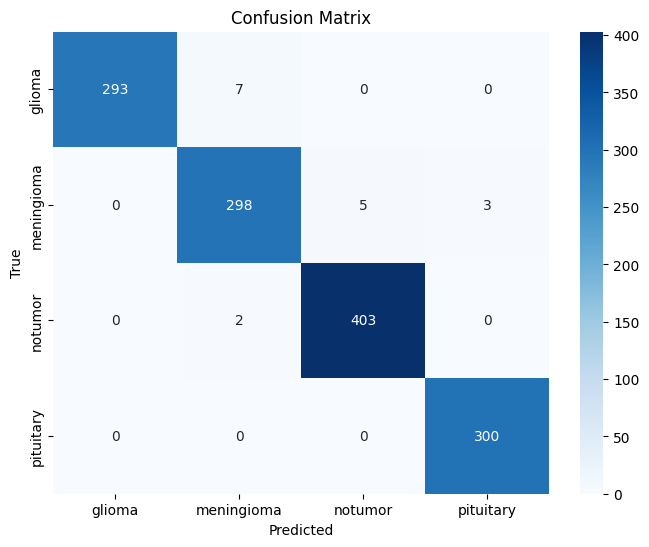

              precision    recall  f1-score   support

      glioma       1.00      0.98      0.99       300
  meningioma       0.97      0.97      0.97       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.99      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



In [9]:
# Evaluation
def evaluate(model, test_ds):
    results = model.evaluate(test_ds)
    print(f"Test Results - Loss: {results[0]}, Accuracy: {results[1]}, Precision: {results[2]}, Recall: {results[3]}")

    y_true = []
    y_pred = []
    for images, labels in test_ds:
        preds = model.predict(images)
        y_pred.extend(np.argmax(preds, axis=1))
        y_true.extend(np.argmax(labels.numpy(), axis=1))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    print(classification_report(y_true, y_pred, target_names=CLASSES))

# MAIN
def main():
    train_ds, val_ds, test_ds = prepare_datasets()
    class_weights = get_class_weights(train_ds)
    model, base_model = build_model()
    history1, history2 = train(model, base_model, train_ds, val_ds, class_weights)
    evaluate(model, test_ds)

if __name__ == "__main__":
    main()

In [10]:
!zip -r best_model.zip best_model.keras

	zip warning: name not matched: best_model.keras

zip error: Nothing to do! (try: zip -r best_model.zip . -i best_model.keras)


/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
